In [246]:
import numpy as np
from scipy.sparse.linalg import LinearOperator
from scipy.integrate import quad
from scipy.linalg import solve
from typing import Callable
from matplotlib import pyplot as plt
import time
import pandas as pd

We consider a two-point boundary value problem:

$$
\left\{
\begin{aligned}
  -pu''(x) + qu(x) = f(x) \\
  u(a) = 0 \quad
  u(b) = 0
\end{aligned}
\right.
$$

In [247]:
N: np.int64 = 10
K: np.int64 = 94

a: np.float64 = np.floor(np.pi*(N + 10))
b: np.float64 = a + K/50 + 2

p: np.float64 = K*np.exp(10*N/K)
q: np.float64 = N*np.sin(np.power(K, N)) + 2*K

print(f'Segment boundaries: {a}, {b}')
print(f'Coeffiсients:       {p}, {q}')

Segment boundaries: 62.0, 65.88
Coeffiсients:       272.35995884348756, 184.2541767404671


$\displaystyle u = -\cosh{\left(x-a-\frac{b-a}{2}\right)}+\cosh{\left(-\frac{b-a}{2} \right)} \implies \frac{du}{dx} = -\sinh{\left(x-a-\frac{b-a}{2}\right)} \implies \frac{d^2u}{dx^2} = -\cosh{\left(x-a-\frac{b-a}{2}\right)}$


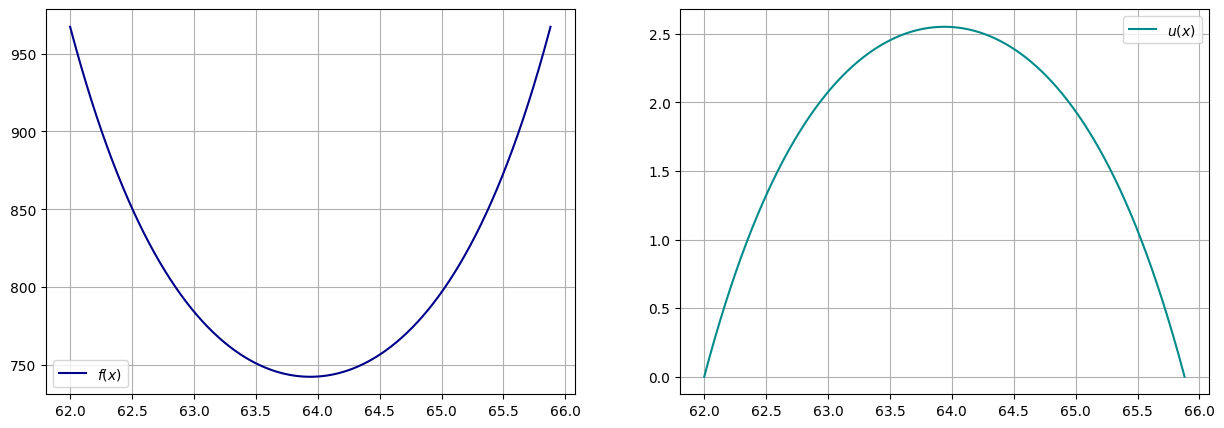

Zeros of test function
u(a) = 0.0
u(b) = 0.0


In [248]:
aver: np.float64 = a + (b-a)/2

u:   Callable[[np.float64], np.float64] = lambda x: -np.cosh(x - aver) + np.cosh(a - aver)
du:  Callable[[np.float64], np.float64] = lambda x: -np.sinh(x - aver)
ddu: Callable[[np.float64], np.float64] = lambda x: -np.cosh(x - aver)

f = lambda x: -p*ddu(x) + q*u(x)

func = np.array([f, u], dtype=object)
name = np.array(['$f(x)$', '$u(x)$'], dtype=str)
col  = np.array(['darkblue', 'darkcyan'], dtype=str)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
x = np.linspace(a, b, 1000)

for i in range(axs.size):
    axs[i].plot(x, func[i](x), label=name[i], color=col[i])
    axs[i].legend()
    axs[i].grid()

plt.show()

print(f'Zeros of test function\nu(a) = {u(a)}\nu(b) = {u(b)}')

### 1. Construct a difference $FEM$ scheme without creating the matrix $A$. System dimension $n = 4096, 2048, 1024, 512, 256$

In [249]:
nArr = np.array([np.power(2, i)+1 for i in range(8, 13)], dtype=np.int64)[::-1]

def vect(f: Callable[[np.float64], np.float64], n:np.float64)->np.ndarray:
    global a, b
    n += 1
    x, h = np.linspace(a, b, n+1, retstep=True)
    xf = lambda x: x*f(x)
    v = np.zeros(n-1)

    for i in range(1, n):
        v[i-1] = quad(xf, x[i-1], x[i])[0] - x[i-1]*quad(f, x[i-1], x[i])[0] + x[i+1]*quad(f, x[i], x[i+1])[0] - quad(xf, x[i], x[i+1])[0]
    
    return 1*np.power(h, -2)*v

def operator(v:np.ndarray)->np.ndarray:
    global a, b, p, q
    h = (b-a)/v.size

    res1, res2 = np.zeros_like(v), np.zeros_like(v)
    res1[:] += 2*v
    res1[1:] -= v[:-1]
    res1[:-1] -= v[1:]

    res2[:] += 4*v
    res2[1:] += v[:-1]
    res2[:-1] += v[1:]

    return p/(h**2)*res1 + q/6*res2

def buildOperator(n:np.int64)->LinearOperator:
    return LinearOperator((n, n), matvec=operator)

def buildMatrix(A:LinearOperator)->np.ndarray:
    n = A.shape[0]
    return np.column_stack([A(np.eye(n)[:, i]) for i in range(n)])

print(f'Array of dimensions: {nArr-1}')

Array of dimensions: [4096 2048 1024  512  256]


### 2. Implement the conjugate gradient method $(CG)$ in such way that it works with an operator implementing the matrix-vector product corresponding to the method and $FEM$ system.

In [250]:
def CG(A:LinearOperator, b:np.ndarray, maxiter=None, x0=None)->tuple[np.ndarray, np.int64]:
    n: np.int64 = b.size
    if x0 is None:
        x = np.zeros(n)
    else:
        x = x0

    if maxiter is None:
        maxiter = n*10
    dotprod = np.dot
    matvec = A.matvec

    r = b - matvec(x)
    rho_prev, p = None, None

    for iteration in range(maxiter):
        if np.linalg.norm(r, ord=2) < 1e-12:
            return x, 0

        z = matvec(r)
        rho_cur = dotprod(r, z)
        if iteration > 0:
            beta = rho_cur / rho_prev
            p *= beta
            p += z
        else:
            p = np.empty_like(r)
            p[:] = z[:]

        q = matvec(p)
        alpha = rho_cur / dotprod(p, q)
        x += alpha*p
        r -= alpha*q
        rho_prev = rho_cur

    else:
        return x, maxiter

k = 5
v = np.random.uniform(1, 3, k)
print(f'Solution using operator: {CG(buildOperator(k), v)[0]}')
print(f'Solution using matrix:   {solve(buildMatrix(buildOperator(k)), v)}')


Solution using operator: [0.00499604 0.00715331 0.00700642 0.00668308 0.00553081]
Solution using matrix:   [0.00499604 0.00715331 0.00700642 0.00668308 0.00553081]


In [251]:
def thomasMeth(v:np.ndarray)->np.ndarray:
    n: np.int64 = v.size
    A = buildOperator(n)
    belowDiag, diag, aboveDiag = np.zeros(n-1), np.zeros(n), np.zeros(n-1)

    for i in range(n):
        e = np.zeros(n)
        e[i] = 1
        row = A(e)
        diag[i] = row[i]
        if i > 0:
            belowDiag[i-1] = row[i-1]
        if i < n-1:
            aboveDiag[i] = row[i+1]

    c, d = np.zeros(n-1), np.zeros(n)
    c[0] = aboveDiag[0]*np.power(diag[0], -1)
    d[0] = v[0]*np.power(diag[0], -1)

    for i in range(1, n):
        denom = diag[i] - belowDiag[i-1]*c[i-1]
        if i < n-1:
            c[i] = aboveDiag[i]*np.power(denom, -1)
        d[i] = (v[i] - belowDiag[i-1]*d[i-1])*np.power(denom, -1)

    res = np.zeros(n)
    res[-1] = d[-1]
    for i in range(n-2, -1, -1):
        res[i] = d[i] - c[i]*res[i+1]

    return res

k = 5
v = np.random.uniform(1, 3, k)
print(f'Solution using Thomas Method: {thomasMeth(v)}')
print(f'Solution using matrix:        {solve(buildMatrix(buildOperator(k)), v)}')


Solution using Thomas Method: [0.00574748 0.00786344 0.00768524 0.00785786 0.00520158]
Solution using matrix:        [0.00574748 0.00786344 0.00768524 0.00785786 0.00520158]


### 3. Implement the $MGM$.

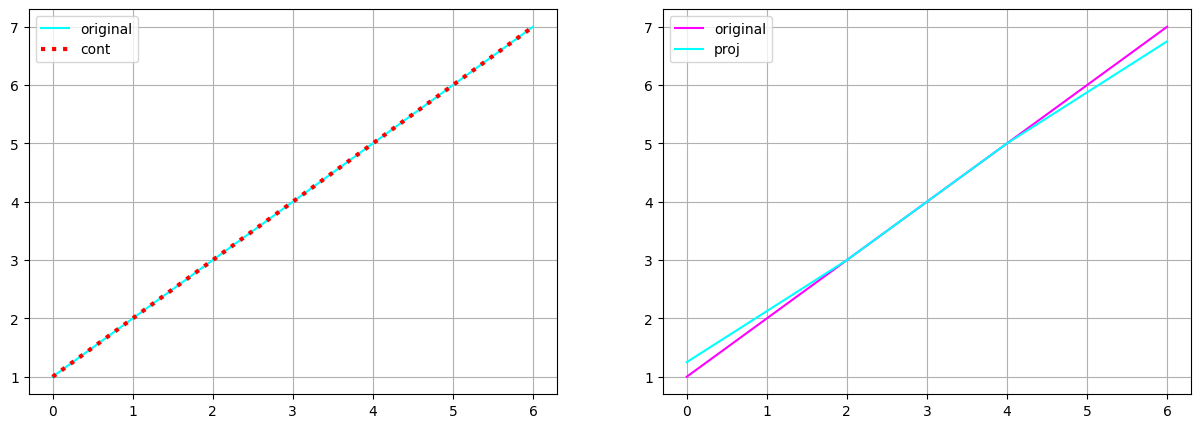

Original vector:  [1. 2. 3. 4. 5. 6. 7.]
Continued vector: [1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7. ]
Projected vector: [1.25 3.   5.   6.75]

Original vector:                  [1. 2. 3. 4. 5. 6. 7.]
Projection of continued vector:   [1.125 2.    3.    4.    5.    6.    6.875]
Continuation of projected vector: [1.25  2.125 3.    4.    5.    5.875 6.75 ]


In [252]:
def cont(x:np.ndarray)->np.ndarray:
    xC = np.zeros(2*x.size - 1)
    xC[::2] = x
    xC[1::2] = 0.5*xC[:-2:2] + 0.5*xC[2::2]

    return xC

def proj(x:np.ndarray)->np.ndarray:
    xP = np.zeros(x.size//2 + 1)
    xP[1:-1] = 0.25*x[1:-2:2] + 0.5*x[2:-1:2] + 0.25*x[3::2]
    xP[0] = 0.75*x[0] + 0.25*x[1]
    xP[-1] = 0.75*x[-1] + 0.25*x[-2]

    return xP

z = 7
x = np.linspace(1, z, z)
xC, xP = cont(x), proj(x)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(np.arange(x.size), x, label='original', color='cyan')
axs[0].plot(np.linspace(0, x.size-1, xC.size), xC, label='cont', color='red', ls=':', lw='3')

axs[1].plot(np.arange(x.size), x, label='original', color='fuchsia')
axs[1].plot(np.linspace(0, x.size-1, xP.size), xP, label='proj', color='cyan')

for ax in axs:
    ax.legend()
    ax.grid()

plt.show()

print(f'Original vector:  {x}\nContinued vector: {xC}\nProjected vector: {xP}\n')
print(f'Original vector:                  {x}\nProjection of continued vector:   {proj(xC)}\nContinuation of projected vector: {cont(xP)}')


-----------------------------------------------MGMW-----------------------------------------------
Estimated time: 0.0199945s


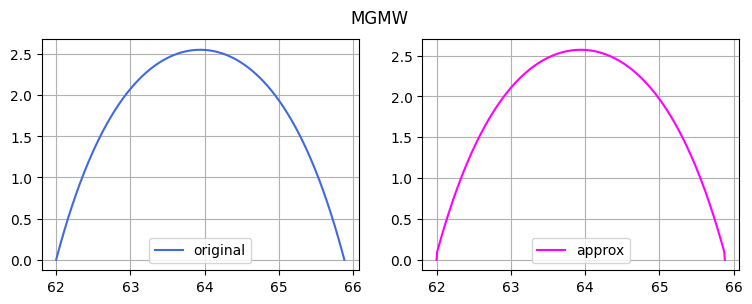

-----------------------------------------------MGMV-----------------------------------------------
Estimated time: 0.00702119s


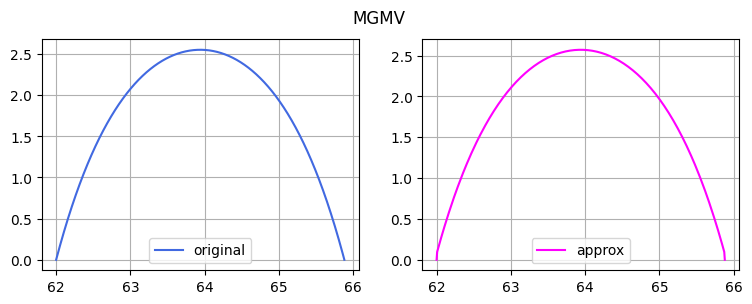

----------------------------------------------MGMFV-----------------------------------------------
Estimated time: 0.01399684s


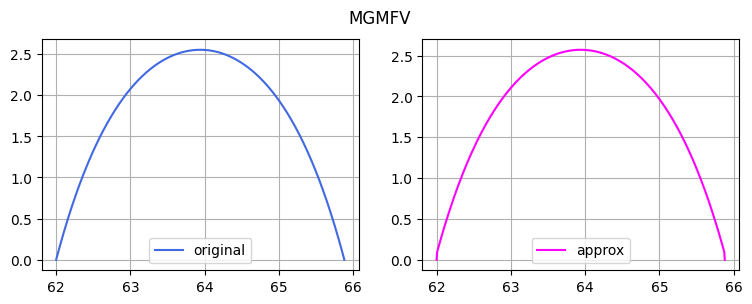

In [274]:
def MGM_auxiliary(x:np.ndarray, b:np.ndarray, nu:np.int64)->tuple[np.ndarray, np.ndarray, np.ndarray]:
    n: np.int64 = x.size
    xNu = CG(buildOperator(n), b, maxiter=nu)[0]
    r = proj(b - buildOperator(n)(xNu))
    return xNu, r, np.zeros(r.size)

def MGMW(k:np.int64, x:np.ndarray, b:np.ndarray, nu:np.int64, post:str='no')->np.ndarray:
    gamma: np.int64 = 2
    if k == 0:
        return thomasMeth(b)
    else:
        if post == 'no':
            xNu, r, e = MGM_auxiliary(x, b, nu)
        else:
            xNu, r, e = MGM_auxiliary(x, b, nu//2)
        for _ in range(gamma):
            e1 = MGMW(k-1, e, r, nu)
            e = e1.copy()
        xNu += cont(e)
        if post != 'no':
            xNu = CG(buildOperator(xNu.size), b, nu//2, xNu)[0]
        return xNu
    
def MGMV(k:np.int64, x:np.ndarray, b:np.ndarray, nu:np.int64, post:str='no')->np.ndarray:
    if k == 0:
        return thomasMeth(b)
    else:
        if post == 'no':
            xNu, r, e = MGM_auxiliary(x, b, nu)
        else:
            xNu, r, e = MGM_auxiliary(x, b, nu//2)
        e1 = MGMV(k-1, e, r, nu)
        e = np.copy(e1)
        xNu += cont(e)
        if post != 'no':
            xNu = CG(buildOperator(xNu.size), b, nu//2, xNu)[0]
        return xNu

def MGMFV(k:np.int64, x:np.ndarray, b:np.ndarray, nu:np.int64, post:str='no')->np.ndarray:
    if k == 0:
        return thomasMeth(b)
    else:
        if post == 'no':
            xNu, r, e = MGM_auxiliary(x, b, nu)
        else:
            xNu, r, e = MGM_auxiliary(x, b, nu//2)
        e1 = MGMFV(k-1, e, r, nu)
        e = MGMV(k-1, e1, r, nu)
        xNu += cont(e)
        if post != 'no':
            xNu = CG(buildOperator(xNu.size), b, nu//2, xNu)[0]
        return xNu
    
mgm = {'MGMW': MGMW, 'MGMV': MGMV, 'MGMFV': MGMFV}
    
def solver(k:np.int64, x:np.ndarray, b:np.ndarray, nu:np.int64, meth:str, post:str='no')->tuple[np.ndarray, np.float64]:
    global mgm
    alpha1 = np.zeros(x.size)
    start = time.time()
    while True:
        alpha = mgm[meth](k, alpha1, b, nu, post)
        if np.linalg.norm(alpha1 - alpha, ord=2) < 1e-5:
            break
        alpha1 = alpha.copy()
    end = time.time()
    return alpha, np.round(end-start, 8)

def drawExamp(n:np.int64, post:str='no'):
    global a, b, u, f, mgm 
    x1 = np.linspace(a, b, n+2)
    for key in mgm.keys():
        x, t = solver(2, np.zeros(n), vect(f, n), 20, key, post)
        x = np.array([0.0]+x.tolist()+[0.0])

        print(f"{key.center(98, '-')}")
        print(f'Estimated time: {t}s')
        
        fig, axs = plt.subplots(1, 2, figsize=(9, 3))
        axs[1].plot(np.linspace(a, b, n+2), x, color='fuchsia', label='approx')
        axs[0].plot(np.linspace(a, b, n+2), u(x1), color='royalblue', label='original')
        for ax in axs:
            ax.legend()
            ax.grid()
        fig.suptitle(f'{key}')
        plt.show()

drawExamp(nArr[-2])

### 4. Fill out the time table for every $n$

![table](tableForLab3.jpg)

In [254]:
def fillTable(meth:str)->list:
    global nArr
    nu = np.int64(np.linspace(10, 100, 10))
    k  = np.int64(np.linspace(1, 10, 10))

    dfs = {n: pd.DataFrame(np.nan, index=k, columns=nu) for n in nArr[::-1]}

    for i, df in enumerate(list(dfs.values())[:3]):
        for j, kVal in enumerate(k[:7+i]):
            for m, nuVal in enumerate(nu):
                #print('start', meth, nArr[-1-i], kVal, nuVal)
                df.iloc[j, m] = solver(kVal, np.zeros(nArr[-1-i]), vect(f, nArr[-1-i]), nuVal, meth)[1]
                #print('end', meth, nArr[-1-i], kVal, nuVal)

    for i, df in enumerate(list(dfs.values())[-2:]):
        for j, kVal in enumerate(k):
            for m, nuVal in enumerate(nu):
                #print('start', meth, nArr[i], kVal, nuVal)
                df.iloc[j, m] = solver(kVal, np.zeros(nArr[i]), vect(f, nArr[i]), nuVal, meth)[1]
                #print('end',meth, nArr[i], kVal, nuVal)
    
    print(f'{meth} done')
    return dfs


In [255]:
dfs = {key: fillTable(key) for key in mgm.keys()}

MGMW done
MGMV done
MGMFV done


### $MGMW\quad n = 256$

In [256]:
dfs['MGMW'][257]

,10,20,30,40,50,60,70,80,90,100
1,0.007963,0.008996,0.009998,0.009996,0.010992,0.009993,0.010992,0.010998,0.011144,0.011000
2,0.009000,0.010000,0.012000,0.013001,0.015000,0.016000,0.017000,0.019000,0.023000,0.021000
3,0.011000,0.014000,0.018000,0.021000,0.025000,0.028000,0.033001,0.034000,0.037000,0.042000
4,0.016000,0.023997,0.031074,0.039000,0.047000,0.059998,0.058000,0.070000,0.073000,0.072007
5,0.028000,0.039000,0.052000,0.058000,0.058000,0.070999,0.077000,0.084001,0.074997,0.088005
6,0.046994,0.048000,0.060000,0.062000,0.063999,0.070000,0.076000,0.076000,0.073000,0.078000
7,0.055011,0.061001,0.077764,0.078000,0.074000,0.083999,0.086000,0.087000,0.087000,0.084000
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### $MGMW\quad n=512$

In [257]:
dfs['MGMW'][513]

,10,20,30,40,50,60,70,80,90,100
1,0.015000,0.016000,0.017046,0.017000,0.017956,0.017930,0.018002,0.019000,0.020949,0.020001
2,0.016000,0.017000,0.020008,0.021000,0.021001,0.023000,0.024000,0.026000,0.030001,0.028780
3,0.018001,0.021000,0.024000,0.030000,0.031000,0.035000,0.041000,0.041000,0.051000,0.047000
4,0.022000,0.030000,0.038000,0.048001,0.053999,0.058992,0.065993,0.071000,0.078000,0.084000
5,0.032000,0.048000,0.060000,0.074001,0.087999,0.109000,0.123001,0.129000,0.132000,0.144000
6,0.052000,0.080001,0.106999,0.115000,0.126999,0.133000,0.143000,0.141000,0.139998,0.148000
7,0.090000,0.106000,0.118018,0.126295,0.132036,0.143899,0.156003,0.150952,0.153956,0.157073
8,0.106004,0.131002,0.136026,0.149027,0.147900,0.159034,0.169927,0.172014,0.170055,0.172044
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### $MGMW\quad n=1024$

In [258]:
dfs['MGMW'][1025]

,10,20,30,40,50,60,70,80,90,100
1,0.030027,0.034112,0.032964,0.032988,0.032800,0.035009,0.034897,0.034956,0.035958,0.036993
2,0.029942,0.030972,0.032933,0.035998,0.036971,0.037953,0.039991,0.041997,0.042971,0.044043
3,0.032993,0.036000,0.037986,0.041962,0.046033,0.049026,0.052027,0.055991,0.062013,0.063993
4,0.035965,0.045033,0.049925,0.057010,0.066965,0.071990,0.079007,0.085993,0.096932,0.101000
5,0.044979,0.059003,0.076975,0.088010,0.107028,0.117000,0.133765,0.145975,0.163977,0.177865
6,0.063941,0.101022,0.122970,0.150934,0.181035,0.208990,0.238405,0.264867,0.260938,0.283965
7,0.101036,0.158991,0.216983,0.234001,0.243990,0.266048,0.290967,0.298023,0.276011,0.296976
8,0.173006,0.204019,0.243986,0.253311,0.262847,0.286993,0.306998,0.322967,0.294999,0.318995
9,0.213986,0.252006,0.282996,0.294011,0.315991,0.322000,0.357035,0.364000,0.365000,0.359000
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### $MGMW\quad n=2048$

In [259]:
dfs['MGMW'][2049]

,10,20,30,40,50,60,70,80,90,100
1,0.160000,0.160000,0.170000,0.161035,0.162957,0.161998,0.169050,0.163999,0.164929,0.163950
2,0.137982,0.135827,0.139004,0.154001,0.143001,0.148961,0.146958,0.151976,0.153970,0.156991
3,0.128995,0.136870,0.139066,0.145969,0.149964,0.152992,0.160082,0.163967,0.171994,0.174961
4,0.126968,0.131988,0.142059,0.157002,0.167989,0.169990,0.180005,0.192993,0.207138,0.209042
5,0.138992,0.152997,0.166957,0.186901,0.203960,0.220080,0.241012,0.257901,0.272956,0.289060
6,0.150992,0.181970,0.219009,0.247998,0.279993,0.316002,0.356025,0.378000,0.418999,0.444000
7,0.191000,0.252000,0.314000,0.385000,0.440000,0.498999,0.561761,0.628853,0.686968,0.748096
8,0.270667,0.390003,0.511991,0.631052,0.753975,0.884929,1.001889,1.174819,1.127020,1.207995
9,0.432866,0.670001,0.911999,0.984999,1.023920,1.152990,1.199009,1.131062,1.165772,1.248765
10,0.725984,0.871021,1.046531,1.073897,1.090984,1.212801,1.280872,1.219958,1.259678,1.342020


### $MGMW\quad n=4096$

In [260]:
dfs['MGMW'][4097]

,10,20,30,40,50,60,70,80,90,100
1,0.067111,0.067966,0.068967,0.070360,0.069997,0.071977,0.072052,0.074072,0.074999,0.074985
2,0.064993,0.067031,0.068970,0.070964,0.073989,0.075992,0.080065,0.080044,0.081006,0.084992
3,0.062977,0.066974,0.070964,0.076065,0.082001,0.085964,0.088733,0.092003,0.096960,0.100969
4,0.067061,0.077006,0.084999,0.091012,0.100981,0.108932,0.117990,0.128004,0.134964,0.146830
5,0.075889,0.091962,0.106933,0.127002,0.142997,0.155981,0.173996,0.186986,0.202920,0.221919
6,0.096926,0.125000,0.157274,0.187000,0.218000,0.250000,0.281000,0.312000,0.343032,0.375217
7,0.134976,0.193996,0.255775,0.317997,0.375960,0.439943,0.500158,0.542894,0.579995,0.605092
8,0.215987,0.334895,0.461957,0.488990,0.507005,0.561926,0.617977,0.573101,0.604262,0.629000
9,0.361753,0.438933,0.507735,0.529964,0.549077,0.603019,0.654961,0.612097,0.651968,0.685004
10,0.449999,0.512814,0.594999,0.613000,0.630999,0.685999,0.739999,0.694999,0.722700,0.745480


### $MGMV\quad n=256$

In [261]:
dfs['MGMV'][257]

,10,20,30,40,50,60,70,80,90,100
1,0.004998,0.003978,0.005997,0.006036,0.008038,0.006931,0.007999,0.008002,0.007998,0.008999
2,0.002940,0.003956,0.004987,0.006000,0.006997,0.007999,0.008923,0.010029,0.011019,0.011105
3,0.002993,0.005008,0.005954,0.007021,0.008990,0.012000,0.011985,0.012921,0.014020,0.017055
4,0.002935,0.004992,0.005991,0.007994,0.009893,0.012025,0.016005,0.017997,0.017954,0.019006
5,0.003002,0.005970,0.007921,0.010018,0.011896,0.012986,0.015026,0.017056,0.017067,0.017912
6,0.002990,0.004989,0.008041,0.008989,0.014025,0.012998,0.014968,0.015995,0.017891,0.018942
7,0.002996,0.005990,0.007989,0.009000,0.010966,0.013995,0.014950,0.015995,0.018092,0.018932
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### $MGMV\quad n=512$

In [262]:
dfs['MGMV'][513]

,10,20,30,40,50,60,70,80,90,100
1,0.008098,0.007973,0.008999,0.009971,0.012034,0.010993,0.012002,0.011995,0.011898,0.013094
2,0.004992,0.005998,0.006999,0.008008,0.010008,0.010033,0.010930,0.012933,0.013992,0.014998
3,0.005969,0.005992,0.006000,0.008009,0.009899,0.011025,0.013005,0.016990,0.016044,0.018001
4,0.002913,0.005899,0.008106,0.009970,0.011892,0.013930,0.015100,0.017007,0.024961,0.021998
5,0.003999,0.010972,0.009101,0.010979,0.013004,0.015887,0.018995,0.019958,0.022079,0.024973
6,0.004022,0.006925,0.010070,0.012028,0.015035,0.017025,0.019990,0.022014,0.022949,0.028943
7,0.004103,0.007982,0.009999,0.011954,0.013937,0.016901,0.018992,0.021036,0.022989,0.025026
8,0.004000,0.008959,0.009994,0.011898,0.013999,0.016995,0.019896,0.021911,0.023096,0.024928
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### $MGMV\quad n=1024$

In [263]:
dfs['MGMV'][1025]

,10,20,30,40,50,60,70,80,90,100
1,0.015999,0.016992,0.018003,0.018067,0.018996,0.020978,0.019997,0.021002,0.022005,0.022933
2,0.009048,0.010053,0.011057,0.011927,0.013003,0.014994,0.015965,0.018998,0.018006,0.019008
3,0.004989,0.006945,0.008989,0.010901,0.012063,0.014056,0.016036,0.017061,0.020045,0.020102
4,0.004991,0.005995,0.009028,0.010047,0.013056,0.015913,0.017021,0.019903,0.022067,0.023955
5,0.003992,0.007054,0.009013,0.012970,0.013992,0.017050,0.019992,0.021998,0.024995,0.028018
6,0.004044,0.008050,0.009923,0.014057,0.016979,0.019945,0.022094,0.026002,0.027937,0.030946
7,0.005040,0.008104,0.011999,0.015001,0.018040,0.020000,0.022948,0.029929,0.028008,0.031046
8,0.004995,0.009056,0.011979,0.015042,0.016994,0.019989,0.023062,0.026014,0.027917,0.031001
9,0.004990,0.008039,0.011951,0.014901,0.017990,0.019954,0.023000,0.027002,0.027972,0.030991
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### $MGMV\quad n=2048$

In [264]:
dfs['MGMV'][2049]

,10,20,30,40,50,60,70,80,90,100
1,0.083048,0.081087,0.081996,0.083971,0.084979,0.085975,0.083004,0.087993,0.088031,0.089999
2,0.036029,0.037971,0.038923,0.040000,0.047000,0.044000,0.051000,0.050000,0.052000,0.052000
3,0.019000,0.021000,0.024000,0.027000,0.028000,0.031000,0.033000,0.037000,0.038000,0.067004
4,0.011000,0.014000,0.017000,0.020000,0.023000,0.027000,0.028000,0.031000,0.038000,0.038000
5,0.008000,0.012000,0.015451,0.019000,0.023000,0.025000,0.030000,0.032000,0.036000,0.040000
6,0.007000,0.011000,0.014000,0.018993,0.023025,0.025927,0.030004,0.034996,0.038045,0.041993
7,0.006024,0.011034,0.015004,0.019997,0.024097,0.028980,0.032989,0.037962,0.042020,0.048014
8,0.006998,0.011051,0.016009,0.021965,0.025925,0.031067,0.036110,0.040974,0.045040,0.049042
9,0.006972,0.011963,0.018017,0.021951,0.026991,0.031992,0.036982,0.039963,0.044965,0.048967
10,0.007009,0.012020,0.019020,0.022027,0.026989,0.032049,0.036974,0.039989,0.045021,0.048967


### $MGMV\quad n=4096$

In [265]:
dfs['MGMV'][4097]

,10,20,30,40,50,60,70,80,90,100
1,0.035062,0.034996,0.035987,0.036962,0.036995,0.039008,0.038948,0.040100,0.040962,0.040966
2,0.018025,0.019027,0.020982,0.020956,0.021983,0.024973,0.025010,0.027052,0.028953,0.030033
3,0.010014,0.010975,0.012972,0.014989,0.016993,0.019054,0.020992,0.023016,0.026005,0.026984
4,0.006993,0.008993,0.010923,0.013988,0.016023,0.019024,0.020993,0.024026,0.025021,0.030001
5,0.006001,0.008000,0.012016,0.014960,0.017003,0.019953,0.022988,0.026022,0.032997,0.032990
6,0.004993,0.008000,0.011964,0.014984,0.019140,0.022000,0.026000,0.028999,0.032000,0.036000
7,0.005000,0.009000,0.016000,0.017000,0.020000,0.024000,0.028000,0.031808,0.035000,0.038000
8,0.005000,0.010000,0.015000,0.018000,0.021000,0.025001,0.029000,0.031000,0.036000,0.039000
9,0.006000,0.010000,0.014000,0.018000,0.022000,0.025000,0.033000,0.032000,0.037000,0.038000
10,0.006000,0.010000,0.014000,0.018000,0.021000,0.025000,0.029001,0.032000,0.037000,0.039000


### $MGMFV\quad n=256$

In [266]:
dfs['MGMFV'][257]

,10,20,30,40,50,60,70,80,90,100
1,0.008000,0.008,0.008000,0.010,0.009000,0.010000,0.011000,0.011000,0.012000,0.012
2,0.006999,0.009,0.013000,0.012,0.012000,0.015000,0.016000,0.018000,0.019000,0.021
3,0.008000,0.010,0.012942,0.016,0.019000,0.022000,0.025000,0.027000,0.030000,0.033
4,0.007999,0.013,0.018000,0.023,0.026000,0.031000,0.036999,0.041000,0.044000,0.046
5,0.010000,0.018,0.025000,0.029,0.031000,0.067002,0.072000,0.056999,0.059997,0.057
6,0.015000,0.020,0.027001,0.031,0.031000,0.036786,0.052000,0.045001,0.046000,0.048
7,0.015000,0.020,0.032000,0.035,0.033924,0.037914,0.046007,0.045001,0.049996,0.050
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### $MGMFV\quad n=512$

In [267]:
dfs['MGMFV'][513]

,10,20,30,40,50,60,70,80,90,100
1,0.015000,0.016000,0.017000,0.016999,0.017994,0.018994,0.020032,0.019922,0.021913,0.021000
2,0.014000,0.014996,0.016003,0.019000,0.020000,0.025999,0.029000,0.026003,0.029002,0.030002
3,0.011993,0.014995,0.018992,0.019086,0.022993,0.025750,0.030999,0.031710,0.036000,0.040002
4,0.011085,0.017000,0.019916,0.026000,0.031000,0.037000,0.043000,0.045996,0.051080,0.057914
5,0.012000,0.044002,0.028000,0.038000,0.047002,0.052999,0.065001,0.072000,0.071993,0.074999
6,0.013991,0.029003,0.037006,0.041992,0.049007,0.055009,0.063071,0.067000,0.068000,0.072001
7,0.018992,0.027000,0.036001,0.043999,0.047990,0.053000,0.059661,0.068001,0.069994,0.074586
8,0.019000,0.028000,0.036075,0.041001,0.050002,0.055000,0.062723,0.068001,0.070079,0.075001
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### $MGMFV\quad n=1024$

In [268]:
dfs['MGMFV'][1025]

,10,20,30,40,50,60,70,80,90,100
1,0.034000,0.039000,0.035000,0.036082,0.037000,0.038019,0.036001,0.039079,0.042002,0.040994
2,0.026927,0.027001,0.028925,0.031000,0.031924,0.034925,0.036000,0.039992,0.040000,0.041920
3,0.019000,0.024005,0.025923,0.030000,0.032995,0.035008,0.038000,0.044000,0.046918,0.049995
4,0.016000,0.021997,0.027007,0.031000,0.037000,0.043000,0.061999,0.064902,0.068911,0.077770
5,0.019012,0.027001,0.037000,0.047548,0.055003,0.062000,0.069996,0.076996,0.080996,0.091000
6,0.018000,0.028996,0.039999,0.051000,0.065000,0.074995,0.085000,0.095992,0.100996,0.110998
7,0.020000,0.035000,0.049996,0.059000,0.069000,0.079000,0.089995,0.097000,0.100999,0.108000
8,0.024000,0.035000,0.051000,0.059000,0.068000,0.078000,0.087006,0.097000,0.107000,0.110996
9,0.026000,0.037998,0.053000,0.064000,0.069004,0.080000,0.097001,0.098000,0.102004,0.110992
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### $MGMFV\quad n=2048$

In [269]:
dfs['MGMFV'][2049]

,10,20,30,40,50,60,70,80,90,100
1,0.180000,0.174007,0.177991,0.175999,0.177000,0.177000,0.181008,0.175000,0.178999,0.187003
2,0.111008,0.113915,0.115993,0.118000,0.120001,0.121995,0.128000,0.130000,0.141007,0.135000
3,0.077000,0.078001,0.082999,0.089000,0.090006,0.097003,0.099000,0.109000,0.112000,0.116004
4,0.049000,0.054993,0.063000,0.071993,0.077000,0.083000,0.090000,0.099000,0.105000,0.119001
5,0.037000,0.046000,0.056000,0.067000,0.076000,0.084001,0.096000,0.104999,0.116001,0.125001
6,0.030999,0.044000,0.068001,0.070007,0.083000,0.095000,0.108999,0.131000,0.148999,0.145998
7,0.028001,0.046987,0.061000,0.078000,0.096000,0.111999,0.124006,0.147002,0.161001,0.175996
8,0.031000,0.052000,0.071000,0.093002,0.114001,0.135002,0.151999,0.169997,0.196997,0.205034
9,0.034994,0.061007,0.083001,0.107048,0.119960,0.138000,0.156009,0.168041,0.186001,0.207001
10,0.039999,0.061040,0.084892,0.109999,0.118959,0.137982,0.157998,0.168004,0.189000,0.208032


### $MGMFV\quad n=4096$

In [270]:
dfs['MGMFV'][4097]

,10,20,30,40,50,60,70,80,90,100
1,0.068002,0.076927,0.070998,0.070998,0.071999,0.072970,0.073902,0.074974,0.075000,0.077000
2,0.050000,0.054000,0.055000,0.058000,0.059000,0.062001,0.063000,0.065000,0.067000,0.069000
3,0.034000,0.038000,0.044000,0.045000,0.050040,0.053969,0.055997,0.066931,0.064014,0.067967
4,0.024994,0.031021,0.036889,0.043931,0.048029,0.054075,0.070992,0.066007,0.070967,0.078892
5,0.020999,0.029992,0.037982,0.046000,0.059970,0.063036,0.072021,0.076000,0.086000,0.096000
6,0.020000,0.031762,0.043000,0.053000,0.065000,0.075001,0.090000,0.098000,0.109000,0.120000
7,0.022000,0.037000,0.052000,0.064749,0.080000,0.094000,0.109000,0.121000,0.135000,0.144999
8,0.025000,0.043016,0.064003,0.099072,0.086031,0.099000,0.117000,0.120000,0.133769,0.142000
9,0.029000,0.045000,0.062000,0.075000,0.086000,0.100000,0.115347,0.120973,0.131997,0.148033
10,0.030998,0.045968,0.062944,0.073996,0.086958,0.100001,0.114048,0.121021,0.133993,0.143999


### 5. Compare with the execution time of $CG$.

In [271]:
n = 4097
start = time.time()
x = CG(buildOperator(n), vect(f, n))
end = time.time()
print(f'Estimated time of CG:   {end-start}')
for key in mgm.keys():
    print(f'Estimated time of {key}: {dfs[key][n].iloc[-1, -1]}')

Estimated time of CG:   2.838712453842163
Estimated time of MGMW: 0.74547982
Estimated time of MGMV: 0.0389998
Estimated time of MGMFV: 0.14399862


### 6. Modify the $MGM$ methods by adding post-smoothing after correction from the coarse mesh. Assuming that the number of post-smoothing iterations $\nu_{post}$ is equal to the number of pre-smoothing iterations $\nu_{pre}$ and $\nu_{post} + \nu_{pre} = \nu$, determine how this affected the convergence of the method.

-----------------------------------------------MGMW-----------------------------------------------
Estimated time: 0.01900077s


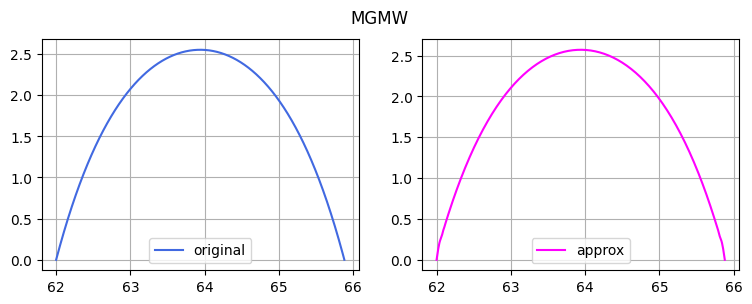

-----------------------------------------------MGMV-----------------------------------------------
Estimated time: 0.00592136s


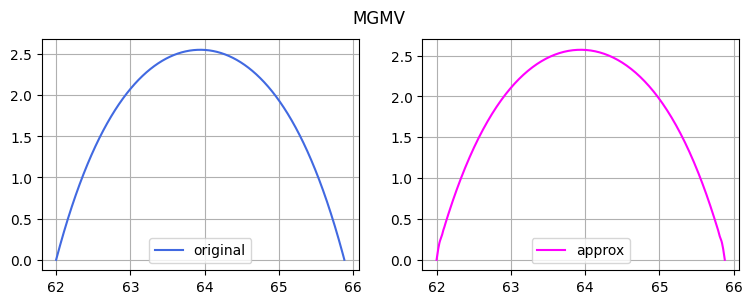

----------------------------------------------MGMFV-----------------------------------------------
Estimated time: 0.0149951s


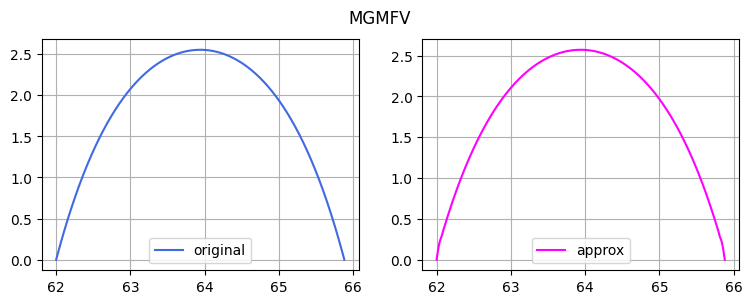

In [273]:
drawExamp(nArr[-2], 'yes')